## Download CPU Benchmark Data

In [0]:
#download and extract data set
#assignment github link https://github.com/snehankekre/CS156/blob/master/CS156_Assignment_1.ipynb
!wget -q http://preshing.com/files/specdata20120207.zip
!unzip -q specdata20120207.zip
!rm specdata20120207.zip

## Import Libraries

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
warnings.simplefilter('ignore') #supress warnings

In [0]:
#yellowbrick is a fanstic library for model diagnostics and visulalization. it is wrapped around matplotlib
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, normalized_mutual_info_score
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(12, 8)})

## Load and Explore Data

In [5]:
data = pd.read_csv('benchmarks.txt', low_memory=False)
data.head()

,testID,benchName,base,peak
0,cpu95-19990104-03254,101.tomcatv,19.40,27.1
1,cpu95-19990104-03254,102.swim,27.20,34.8
2,cpu95-19990104-03254,103.su2cor,10.10,9.98
3,cpu95-19990104-03254,104.hydro2d,8.58,8.61
4,cpu95-19990104-03254,107.mgrid,8.94,9.44


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136995 entries, 0 to 136994
Data columns (total 4 columns):
testID       136995 non-null object
benchName    136995 non-null object
base         136995 non-null float64
peak         131575 non-null object
dtypes: float64(1), object(3)
memory usage: 4.2+ MB


In [7]:
pd.unique(data.benchName) #print unique benchmarks to pick one later

array(['101.tomcatv', '102.swim', '103.su2cor', '104.hydro2d',
       '107.mgrid', '110.applu', '125.turb3d', '141.apsi', '145.fpppp',
       '146.wave5', '099.go', '124.m88ksim', '126.gcc', '129.compress',
       '130.li', '132.ijpeg', '134.perl', '147.vortex', '168.wupwise',
       '171.swim', '172.mgrid', '173.applu', '177.mesa', '178.galgel',
       '179.art', '183.equake', '187.facerec', '188.ammp', '189.lucas',
       '191.fma3d', '200.sixtrack', '301.apsi', '164.gzip', '175.vpr',
       '176.gcc', '181.mcf', '186.crafty', '197.parser', '252.eon',
       '253.perlbmk', '254.gap', '255.vortex', '256.bzip2', '300.twolf',
       '400.perlbench', '401.bzip2', '403.gcc', '429.mcf', '445.gobmk',
       '456.hmmer', '458.sjeng', '462.libquantum', '464.h264ref',
       '471.omnetpp', '473.astar', '483.xalancbmk', '410.bwaves',
       '416.gamess', '433.milc', '434.zeusmp', '435.gromacs',
       '436.cactusADM', '437.leslie3d', '444.namd', '447.dealII',
       '450.soplex', '453.povray', 

## Select Specific Benchmark

In [8]:
#choose the mesa benchmark
mesa_data = data[data['benchName'] == '177.mesa']
mesa_data.head(20)

,testID,benchName,base,peak
9954,cpu2000-19991130-00002,177.mesa,130.0,NaN
9980,cpu2000-19991130-00004,177.mesa,198.0,NaN
10006,cpu2000-19991130-00006,177.mesa,502.0,502
10032,cpu2000-19991130-00008,177.mesa,195.0,NaN
10058,cpu2000-19991130-00010,177.mesa,386.0,366
10084,cpu2000-19991130-00012,177.mesa,511.0,504
10110,cpu2000-19991130-00014,177.mesa,207.0,NaN
10136,cpu2000-19991130-00016,177.mesa,147.0,NaN
10162,cpu2000-19991130-00018,177.mesa,292.0,NaN
10188,cpu2000-19991130-00020,177.mesa,211.0,232


## Extract Date and Base Speed of Benchmark

Note: [`datetime.timestamp()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.timestamp) returns POSIX timestamp corresponding to the `datetime` instance.

In [0]:
mesa_data['date'] = [datetime.strptime(ID.split('-')[1], '%Y%m%d') for ID in mesa_data.testID]
mesa_data['constant'] = 1
#mesa_data['peak'] = mesa_data.peak.fillna(0)
mesa_data.peak = mesa_data.peak.astype(float)
mesa_data['timeStamp'] = [i.timestamp() for i in mesa_data['date']] #extract unix timestamp
mesa_data['baseLog2'] = np.log2(mesa_data.base)
mesa_data['peakLog2'] = np.log2(mesa_data.peak)

Note: For the mesa benchmark, we use the `timeStamp` column as the y-axis to denote time.

## Fit a Linear Model and Plot (base performance)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2

In [11]:
X = mesa_data[['timeStamp', 'constant']] #constant of ones added to accomodate the intercept term
y = mesa_data.baseLog2

X_train, X_test, y_train, y_test = train_test_split(X[:1385], y, random_state=1, test_size=0.3)

linreg = LinearRegression()
linreg.fit(X_train, y_train) #fit the training data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = linreg.predict(X_test) #predict on the test data

In [13]:
print('Coefficients: ', linreg.coef_)
print("RMSE: %.2f" % np.sqrt(MSE(y_test, y_pred)))
print("MAE: %.2f" % MAE(y_test, y_pred))

# Explained variance score: 1 signifies a perfect prediction
print('Variance score (R^2): %.2f' % R2(y_test, y_pred))
r2 = R2(y_test, y_pred)

Coefficients:  [1.21439335e-08 0.00000000e+00]
RMSE: 0.51
MAE: 0.40
Variance score (R^2): 0.69


In [0]:
baseReg = linreg.fit(X, y)
mesa_data['baseReg'] = baseReg

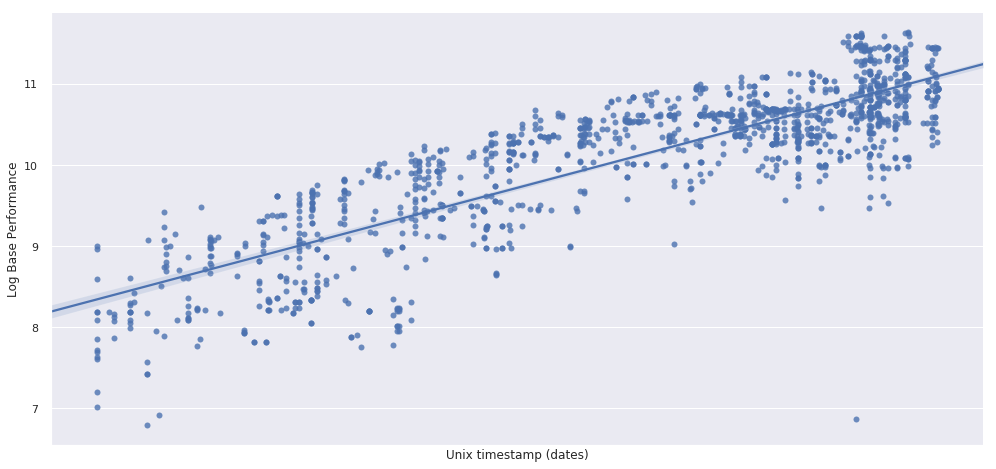

In [15]:
ax = sns.lmplot(x='timeStamp', y='baseLog2', data=mesa_data, size=7, aspect=2)
plt.xlabel('Unix timestamp (dates)')
plt.ylabel('Log Base Performance')
plt.xticks([]);

Moore's Law is roughly holding up, although the data is very noisy. The model used has an $R^2$ of 0.69, implying that around 70% of the variance in $log_2(\text{base performance})$ is explained by the dates. Since the above plot is a log plot, a single unit increase in the Y-axis corresponds to a doubling in the performance.

# MNIST K-nearest Neighbors

In [0]:
from sklearn import datasets, neighbors

digits = datasets.load_digits()

<Figure size 864x576 with 0 Axes>

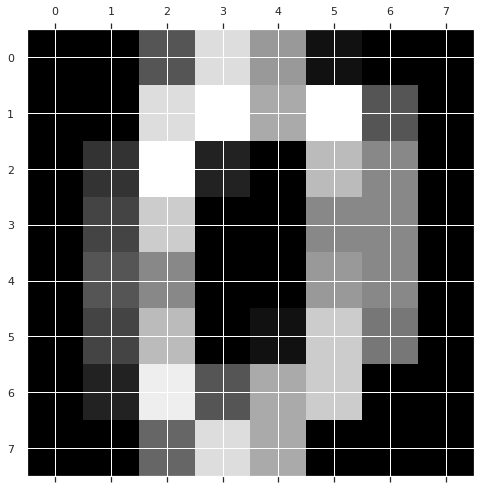

<Figure size 864x576 with 0 Axes>

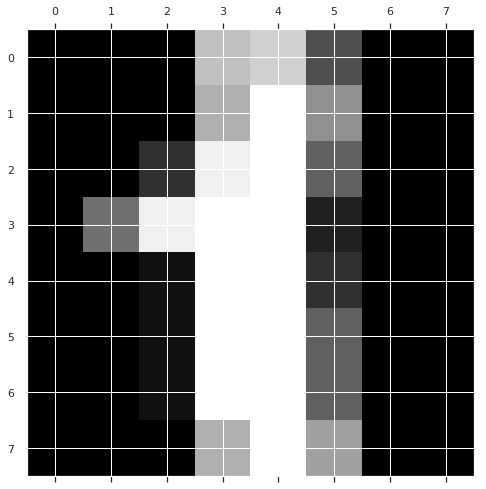

<Figure size 864x576 with 0 Axes>

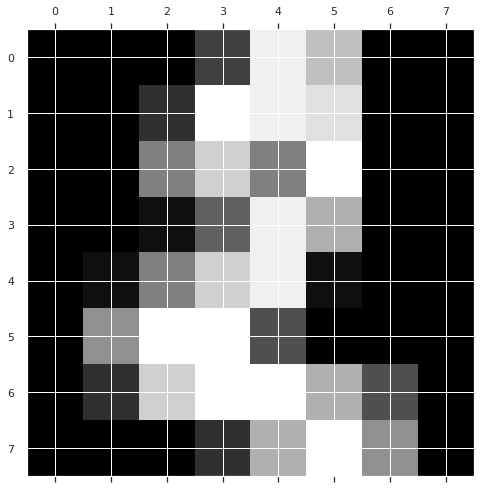

In [17]:
for i in range(3):
    plt.gray() 
    plt.matshow(digits.images[i]) 
    plt.show()

In [18]:
np.random.seed(42)

data_indices_7 = np.where(digits.target == 7)[0]

data_indices_3 = np.where(digits.target == 3)[0]

data_indices_7.shape, data_indices_3.shape

((179,), (183,))

In [0]:
indices = np.concatenate([data_indices_7, data_indices_3]) #select 7 & 3 as target classes
X = digits.data[indices] / digits.data[indices].max() #standardization
y = digits.target[indices]

In [20]:
X.shape, y.shape

((362, 64), (362,))

### Checking for class imbalance

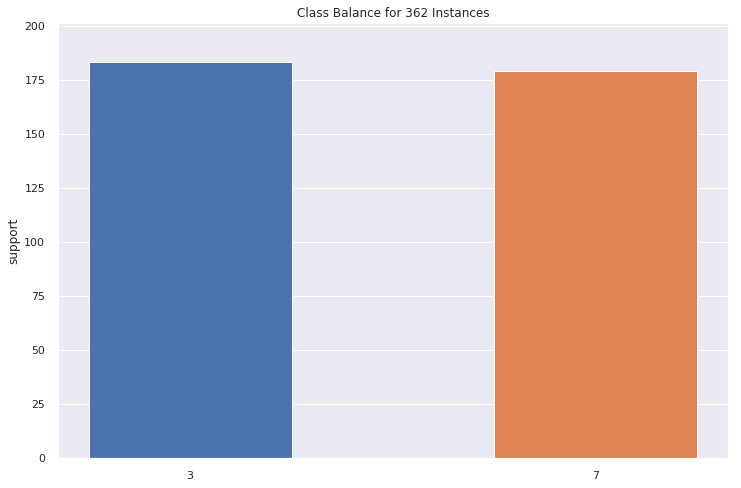

In [21]:
plt.rcParams['figure.figsize'] = (12, 8)
visualizer = ClassBalance(labels=["3", "7"])
visualizer.fit(y)
visualizer.poof()

Note: Classes are almost evenly balanced. This will help us with our model's classification accuracy

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

knn = neighbors.KNeighborsClassifier()

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))

KNN score: 0.989011


In [0]:
mnist_preds = knn.predict(X_test)

In [24]:
print("Test Accuracy: ", accuracy_score(y_test, mnist_preds))
print("Mutual Information: ", normalized_mutual_info_score(y_test, mnist_preds))

Test Accuracy:  0.989010989010989
Mutual Information:  0.9235919135053173


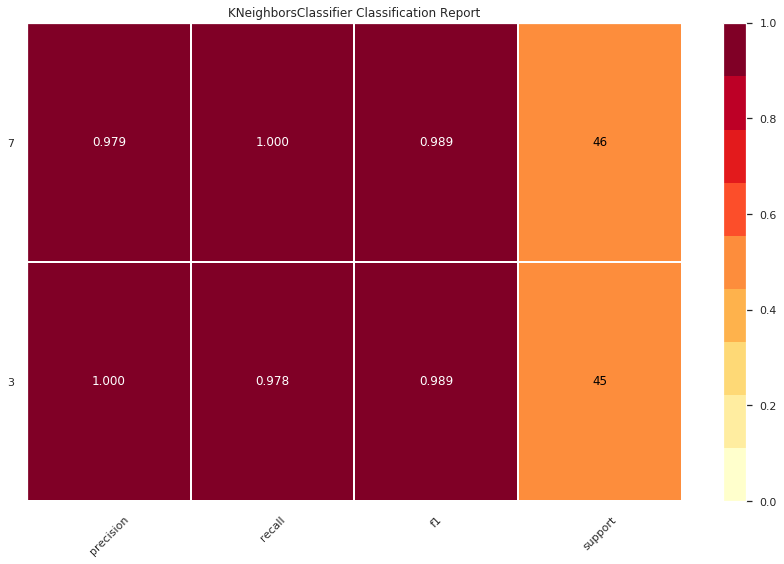

In [25]:
visualizer = ClassificationReport(knn, classes=["3", "7"], support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof()    

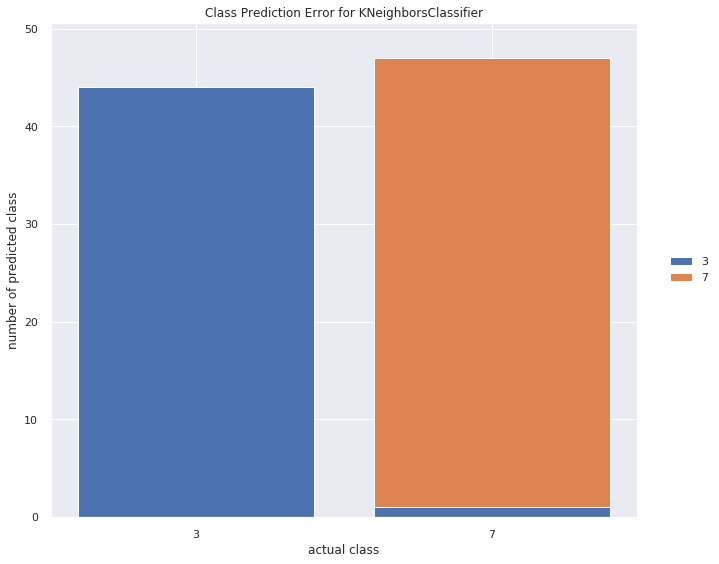

In [26]:
visualizer = ClassPredictionError(knn, classes=["3", "7"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()